In [1]:
import phoebe
import numpy as np
from spice.models.phoebe_model import PhoebeModel
from spice.spectrum import simulate_spectrum
from transformer_payne import Blackbody
from phoebe.parameters.dataset import _mesh_columns
import matplotlib.pyplot as plt
import astropy.units as u
from spice.plots import plot_3D_binary, animate_binary

from jax import config
config.update('jax_platform_name', 'cpu')
config.update("jax_enable_x64", True)

PHOEBE: passband "Bolometric:900-40000" has a newer version available.  Run phoebe.list_passband_online_history("Bolometric:900-40000") to get a list of available changes and phoebe.update_passband("Bolometric:900-40000") or phoebe.update_all_passbands() to update.
PHOEBE: passband "Johnson:V" has a newer version available.  Run phoebe.list_passband_online_history("Johnson:V") to get a list of available changes and phoebe.update_passband("Johnson:V") or phoebe.update_all_passbands() to update.
PHOEBE: passband "Stromgren:b" has a newer version available.  Run phoebe.list_passband_online_history("Stromgren:b") to get a list of available changes and phoebe.update_passband("Stromgren:b") or phoebe.update_all_passbands() to update.


In [2]:
logger = phoebe.logger()

b = phoebe.default_star()
b.add_spot(radius=30, colat=80, long=0, relteff=0.9)
times = np.linspace(0, 10, 11)
b.set_value('period', 10)
b.add_dataset('mesh', times=times, columns=['teffs'])
b.add_dataset('lc', times=times, passband='Gaia:G', dataset='lc01')
b.run_compute(distortion_method='rotstar', irrad_method='none', coordinates='uvw')

Thu, 18 Jul 2024 15:32 BUNDLE       WARNING mesh dataset uses 'compute_times' instead of 'times', applying value sent as 'times' to 'compute_times'.
100%|██████████| 11/11 [00:00<00:00, 298.70it/s]


<ParameterSet: 59 parameters | kinds: mesh, lc>

Thu, 18 Jul 2024 15:32 matplotlib.animation WARNING MovieWriter imagemagick unavailable; using Pillow instead.


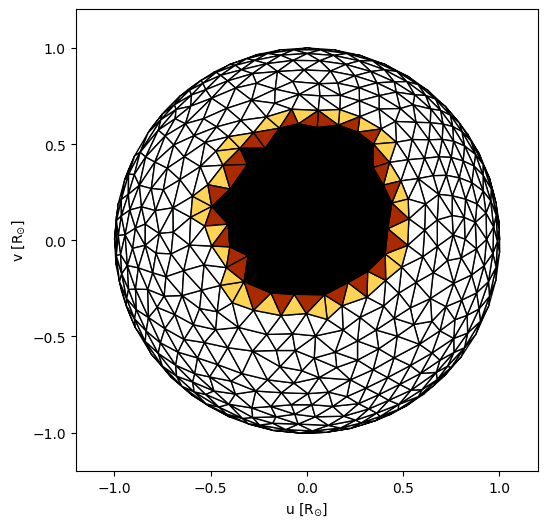

In [3]:
afig, mplfig = b.plot(x='us', y='vs', fc='teffs', dataset='mesh01',
                      animate=True, save='single_spots_1.gif', save_kwargs={'writer': 'imagemagick'})

/Users/majajablonska/miniconda/envs/tp-env/lib/python3.12/site-packages/phoebe/dependencies/autofig/axes.py:1278: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ylim)


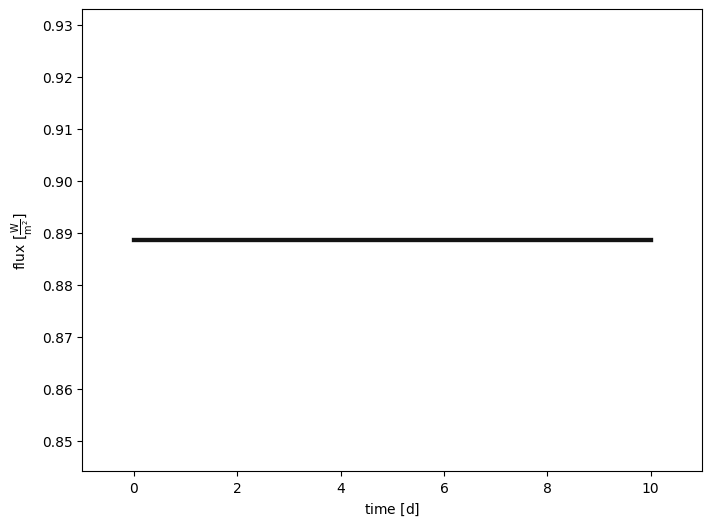

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [4]:
b.plot(dataset='lc01', show=True)